<a href="https://colab.research.google.com/github/rvignav/style-transfer-for-fundus-imaging/blob/main/dr_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data.dataset import Dataset
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import time

In [3]:
class DRDataset(Dataset):
    def __init__(self, csv_path):
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])[1:]
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])[1:]
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        index = index - 1
        # Get image name from the pandas df
        single_image_name = '/content/drive/My Drive/input/' + self.image_arr[index] + '.jpeg'
        # Open image
        img_as_img = Image.open(single_image_name)
        img_as_img = img_as_img.resize((400,300))

        # Transform image to tensor
        img_as_tensor = self.to_tensor(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [4]:
trainset = DRDataset('/content/drive/My Drive/input/trainLabels.csv')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

#TODO: Split train set into train and val set (rename all instances of "test_loader" with "val_loader"): https://stackoverflow.com/questions/43697240/how-can-i-split-a-dataset-from-a-csv-file-for-training-and-testing
#TODO: Convert datasets to Hdf5: https://stackoverflow.com/questions/32358443/converting-a-dataset-into-an-hdf5-dataset
#TODO: Apply style transfer data augmentation

In [5]:
"""
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR
"""
classes = ('none', 'mild', 'moderate', 'severe', 'proliferative')

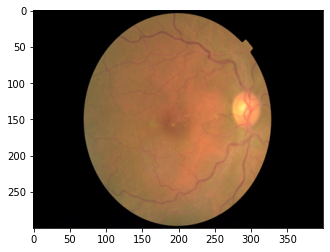

2: moderate


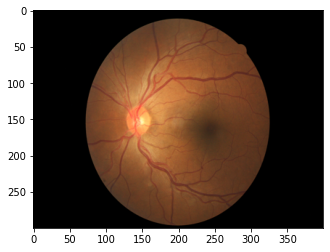

0: none


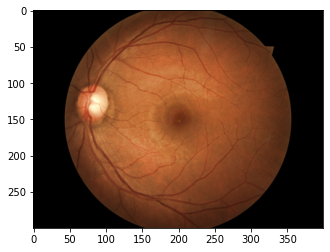

0: none


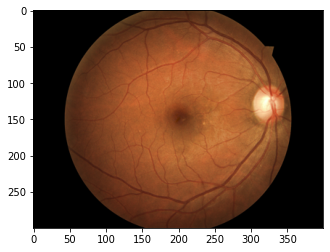

0: none


In [6]:
for data, target in train_loader:
    for i in range(0, 4):  
        im = data[i]
        im = torch.squeeze(im)
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
        plt.show()
        print(target[i] + ": " + classes[(int)(target[i])])
    break

In [7]:
network = torchvision.models.vgg16() 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.005, momentum=0.5, weight_decay=1e-4)

summary(network, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

In [8]:
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 512)),
                           ('relu', nn.ReLU()), 
                           ('dropout', nn.Dropout(p=0.337)),
                           ('fc2', nn.Linear(512, 5)),
                           ('output', nn.LogSoftmax(dim=1))
                             ]))

network.classifier = classifier

In [9]:
def train(model, loader, criterion):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, t in iter(loader):
        y_train = np.zeros(len(t))
        for i in range(len(t)):
            y_train[i] = int(t[i])
        y_train = torch.from_numpy(y_train).long()
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(train_loader.dataset)
    epoch_acc = current_correct.double() / len(train_loader.dataset)
        
    return epoch_loss, epoch_acc

In [10]:
def validation(model, loader, criterion):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, t in iter(loader):
        y_valid = np.zeros(len(t))
        for i in range(len(t)):
            y_valid[i] = int(t[i])
        y_valid = torch.from_numpy(y_valid).long()
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(test_loader.dataset)
    epoch_acc = valid_correct.double() / len(test_loader.dataset)
    
    return epoch_loss, epoch_acc

In [11]:
for param in network.parameters():
    param.require_grad = False
#train and validate
epochs = 2  
epoch = 0
#send model to GPU

    
for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(network,train_loader, criterion)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
with torch.no_grad():
    epoch_val_loss, epoch_val_acc = validation(network, test_loader, criterion)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 1.6060  Train Accuracy: 0.0909
2
Epoch: 2 Train Loss : 1.6057  Train Accuracy: 0.0000
Epoch: 2 Validation Loss : 1.6050  Validation Accuracy 0.1818


In [16]:
network.eval()
total = 0
correct = 0 
count = 0
#iterating for each sample in the test dataset once
for test, t in iter(test_loader):
#     test, y_test = test.to('cuda'), y_test.to('cuda')
#Calculate the class probabilities (softmax) for img
    y_test = np.zeros(len(t))
    for i in range(len(t)):
        y_test[i] = int(t[i])
    y_test = torch.from_numpy(y_test)
    with torch.no_grad():
        output = network.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

Accuracy of network on test images is ... 18.1818....count: 1


In [27]:
torch.save(network.state_dict(), 'dr.pth')
from google.colab import files
files.download('dr.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

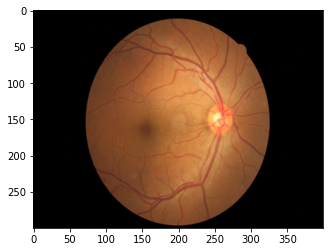

TARGET-- 1: mild
PREDICTION-- 0: none


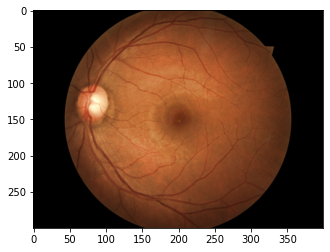

TARGET-- 0: none
PREDICTION-- 0: none


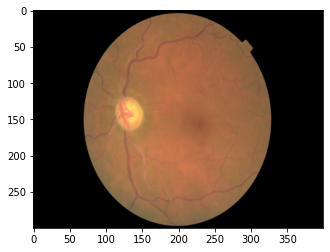

TARGET-- 1: mild
PREDICTION-- 3: severe


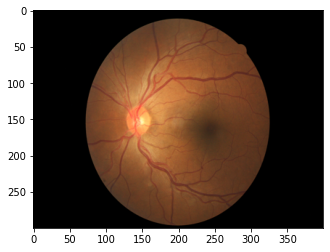

TARGET-- 0: none
PREDICTION-- 0: none


In [25]:
for data, target in test_loader:
    outputs = network(data)
    _, predicted = torch.max(outputs, 1)
    for i in range(0, 4):  
        im = data[i]
        im = torch.squeeze(im)
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
        plt.show()
        print("TARGET-- " + target[i] + ": " + classes[(int)(target[i])])
        # print(predicted[i].numpy())
        print("PREDICTION-- " + str(predicted[i].numpy()) + ": " + classes[predicted[i].numpy()])
    break